In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile 
from zipfile import ZipFile 



# opening the zip file in READ mode 
file_name = "playground-series-s4e7.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir()
    
    
# import
df_zip = zipfile.ZipFile(file_name)
train = pd.read_csv(df_zip.open('train.csv'))
test = pd.read_csv(df_zip.open('test.csv'))
sample_submission = pd.read_csv(df_zip.open('sample_submission.csv')) 

File Name                                             Modified             Size
sample_submission.csv                          2024-06-24 13:46:18     99708270
test.csv                                       2024-06-24 13:46:24    433918183
train.csv                                      2024-06-24 13:46:48    662779095


# EDA

## Dataset summary

In [2]:
train.info()

len(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


11504798

## Sample EDA

Since the dataset is extremely large (11~ million rows), let's do some preliminary EDA on a subset. 

In [3]:


import random

n = len(train) # Calculate number of rows in file
s = n//10  # sample size of 10%
skip = sorted(random.sample(range(1, n+1), n-s))   
train_sample = pd.read_csv(df_zip.open('train.csv'), skiprows = skip)
train_sample


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,13,Male,27,1,28.0,1,< 1 Year,No,43746.0,152.0,259,0
1,14,Female,24,1,12.0,1,< 1 Year,No,23692.0,152.0,245,0
2,23,Female,24,1,8.0,0,< 1 Year,Yes,33752.0,160.0,38,0
3,24,Female,42,1,11.0,0,1-2 Year,Yes,21473.0,26.0,152,0
4,39,Male,27,1,28.0,1,< 1 Year,No,28982.0,152.0,160,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1150474,11504715,Male,22,1,41.0,1,< 1 Year,No,28322.0,152.0,162,0
1150475,11504720,Male,56,1,41.0,0,1-2 Year,Yes,38115.0,12.0,165,0
1150476,11504762,Male,55,1,28.0,1,1-2 Year,No,56871.0,26.0,33,0
1150477,11504768,Female,22,1,8.0,0,< 1 Year,Yes,30106.0,152.0,254,0



### Columns, values

In [4]:
train_sample.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,13,Male,27,1,28.0,1,< 1 Year,No,43746.0,152.0,259,0
1,14,Female,24,1,12.0,1,< 1 Year,No,23692.0,152.0,245,0
2,23,Female,24,1,8.0,0,< 1 Year,Yes,33752.0,160.0,38,0
3,24,Female,42,1,11.0,0,1-2 Year,Yes,21473.0,26.0,152,0
4,39,Male,27,1,28.0,1,< 1 Year,No,28982.0,152.0,160,0
5,40,Female,67,1,28.0,0,1-2 Year,Yes,2630.0,122.0,81,0
6,49,Female,30,1,24.0,1,< 1 Year,No,31300.0,152.0,158,0
7,52,Male,23,1,8.0,1,< 1 Year,No,24282.0,152.0,94,0
8,61,Male,23,1,8.0,1,< 1 Year,No,49614.0,152.0,129,0
9,63,Female,39,1,41.0,0,1-2 Year,Yes,35186.0,124.0,11,0



Based on this output we can further categorize our columns.
- Categorical multi: Region code, Vehicle Age, Policy Sales Channel
- Categorical binary: Gender, Vehicle Age

I suspect Driving License and Vintage are categorical too so let's see what values there are.

In [5]:
train_sample["Driving_License"].value_counts()

1    1148221
0       2258
Name: Driving_License, dtype: int64

In [6]:
train_sample["Vintage"].value_counts()

187    9824
282    9570
131    9267
256    9212
232    8530
       ... 
61     1631
26     1623
32     1562
41     1522
50     1426
Name: Vintage, Length: 290, dtype: int64


There's enough integers for me to think it represents an actual meaningful interval scale. Since the dataset is based on car insurance, this could be some value attached to insurance for vintage/collector cars. It looks like driving license just represents a binary yes/no so we can leave it for now. 

### Row independence


In [7]:
train_sample["id"].value_counts().sort_values( ascending = False).head(10)

13     1
64     1
39     1
40     1
49     1
52     1
270    1
61     1
74     1
23     1
Name: id, dtype: int64


From our sample of ~1 million rows, we don't see duplicates. While it's good practice to check across the whole dataset, I'm aware this is a fairly curated dataset so it should be safe to say the data points are independent person-wise. 

## Univariate visualization

### y - Response

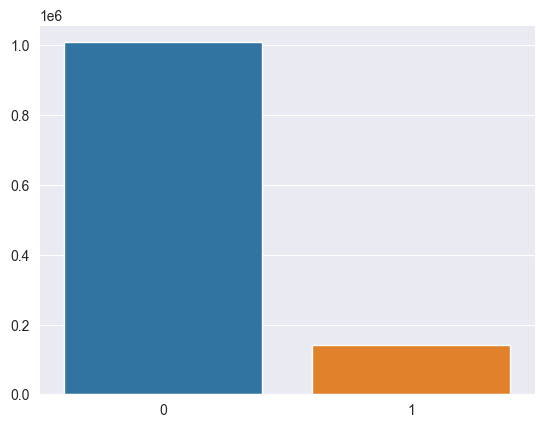

In [8]:

y_counts = train_sample.Response.value_counts()
fig_exit = sns.barplot(x = y_counts.index, y = y_counts.values)
y_counts
train_sample.Response.value_counts(normalize = True)
plt.show()
plt.close("all")



In our sample the cross-sell rate is fairly low as an outcome, ~12%. We'll stratify when we do our train-test split. 


### Categorical

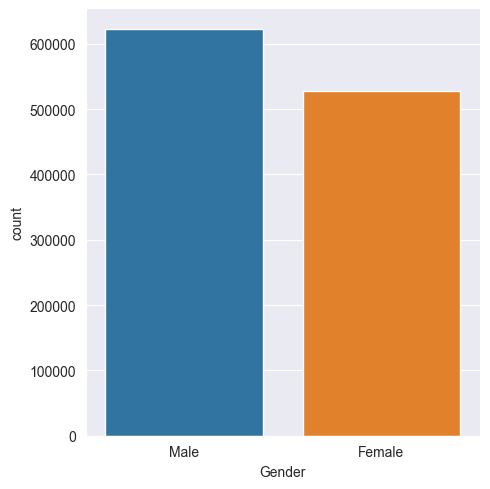

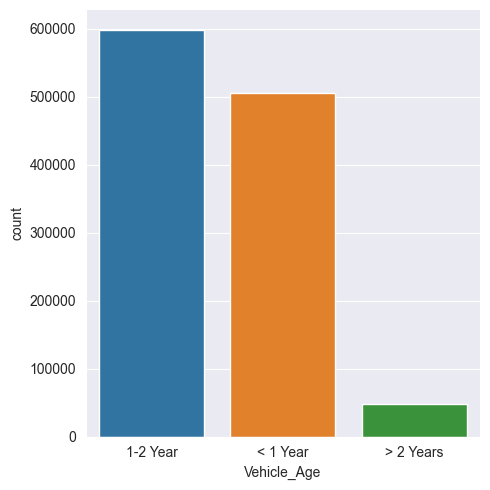

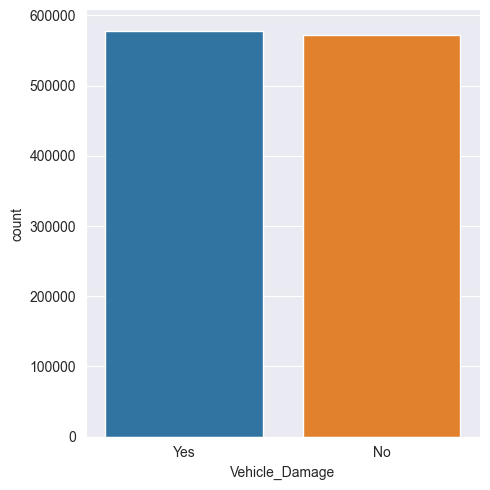

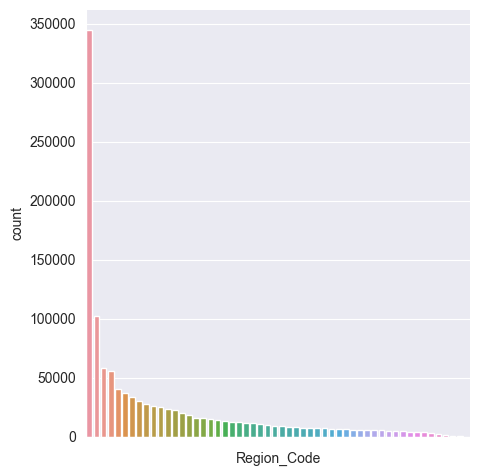

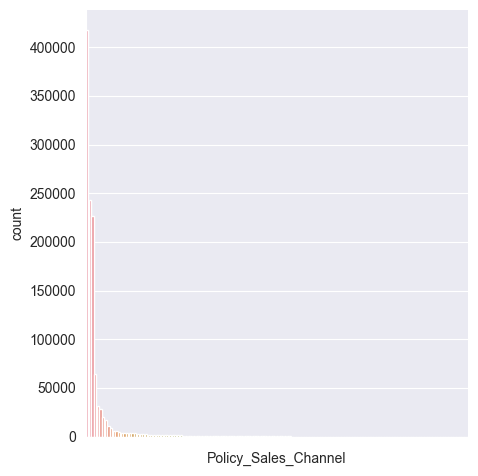

In [9]:
strings = ['object']
string_df = train_sample.select_dtypes(include = strings)
other_cat = train_sample[["Region_Code", "Policy_Sales_Channel"]].astype("category")
cat_df = pd.concat([string_df,other_cat] , axis = 1)

for col in cat_df.columns:
  cat_desc = sns.catplot(x = col, data = cat_df, kind = "count",
                          order = cat_df[col].value_counts().index)
  if col in ["Region_Code", "Policy_Sales_Channel"]:
    # plt.xticks(rotation=90)
    cat_desc.set(xticklabels = [])
  plt.show()
  plt.close("all")

### Numerical

#### Univariate 

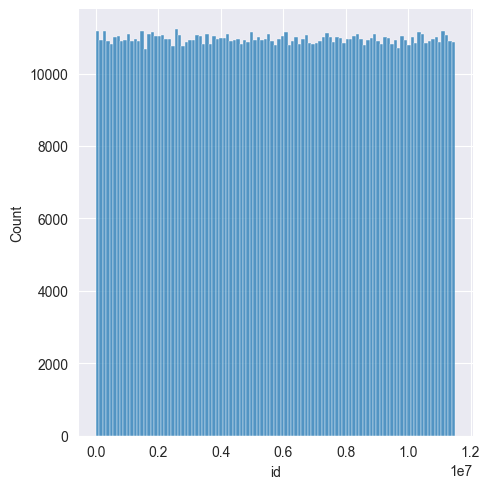

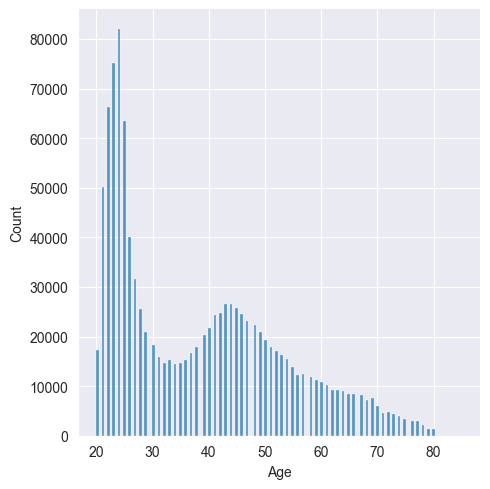

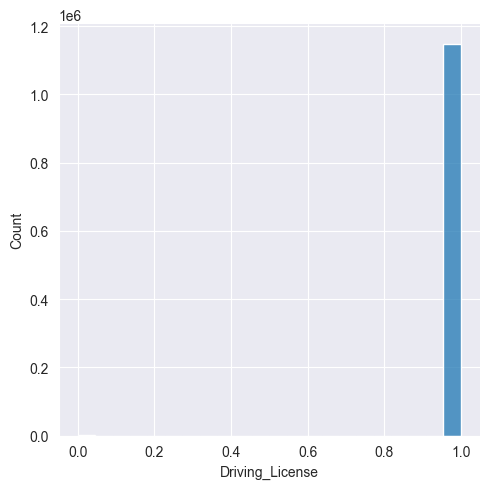

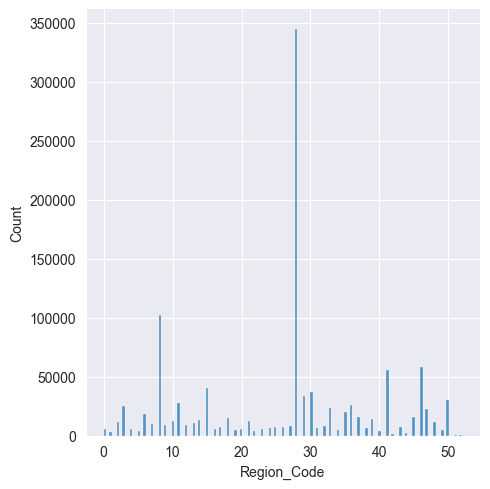

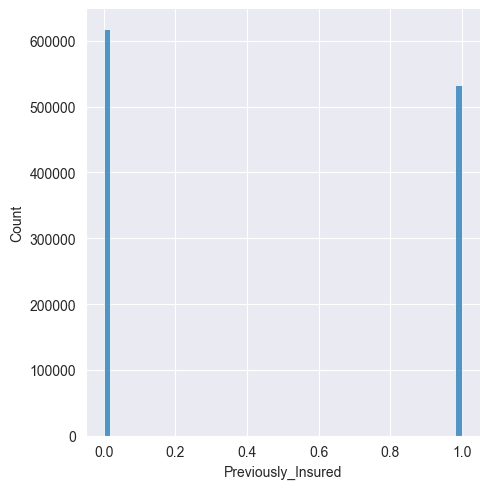

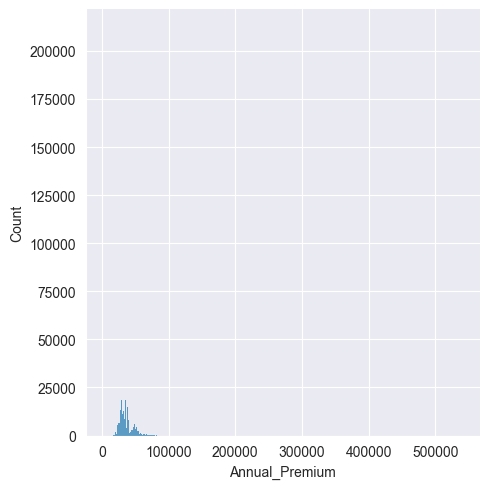

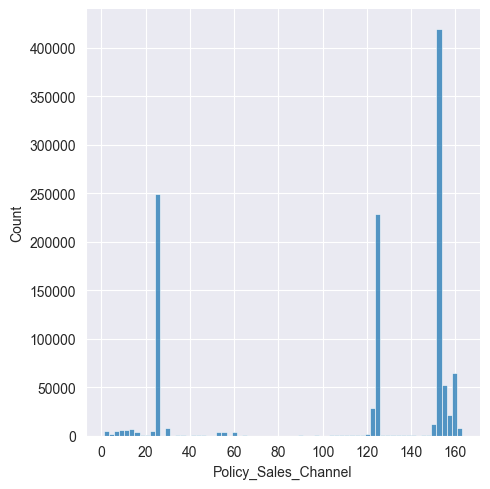

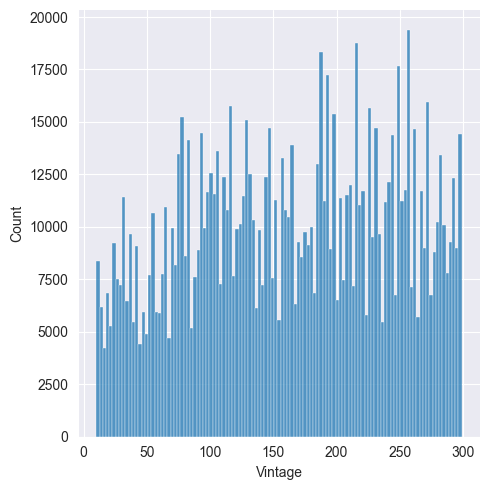

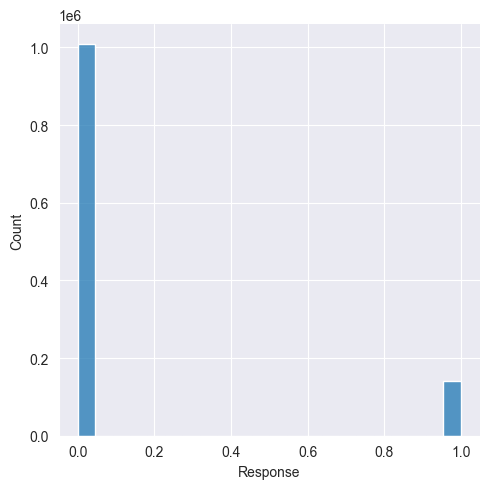

In [10]:
from seaborn import histplot
numeric_df = train_sample.select_dtypes(include = "number")

for col in numeric_df.columns:
  sns.displot(numeric_df, x=col)
  plt.show()
  plt.close("all")



Several observations can be made here:
1. Driver license is heavily imbalanced (mostly licensed)
2. Certain regions are more popular
3. Age distribution has two peaks, mid 20s and mid 40s. 
4. Policy sales mostly come from 3 sources
5. Annual premium is very zoomed out. There's likely outlier(s) on the top end

As a first pass-through we'll run the model(s) with these observations baked in. We note them here as possible avenues for model improvement later.

#### Heat map

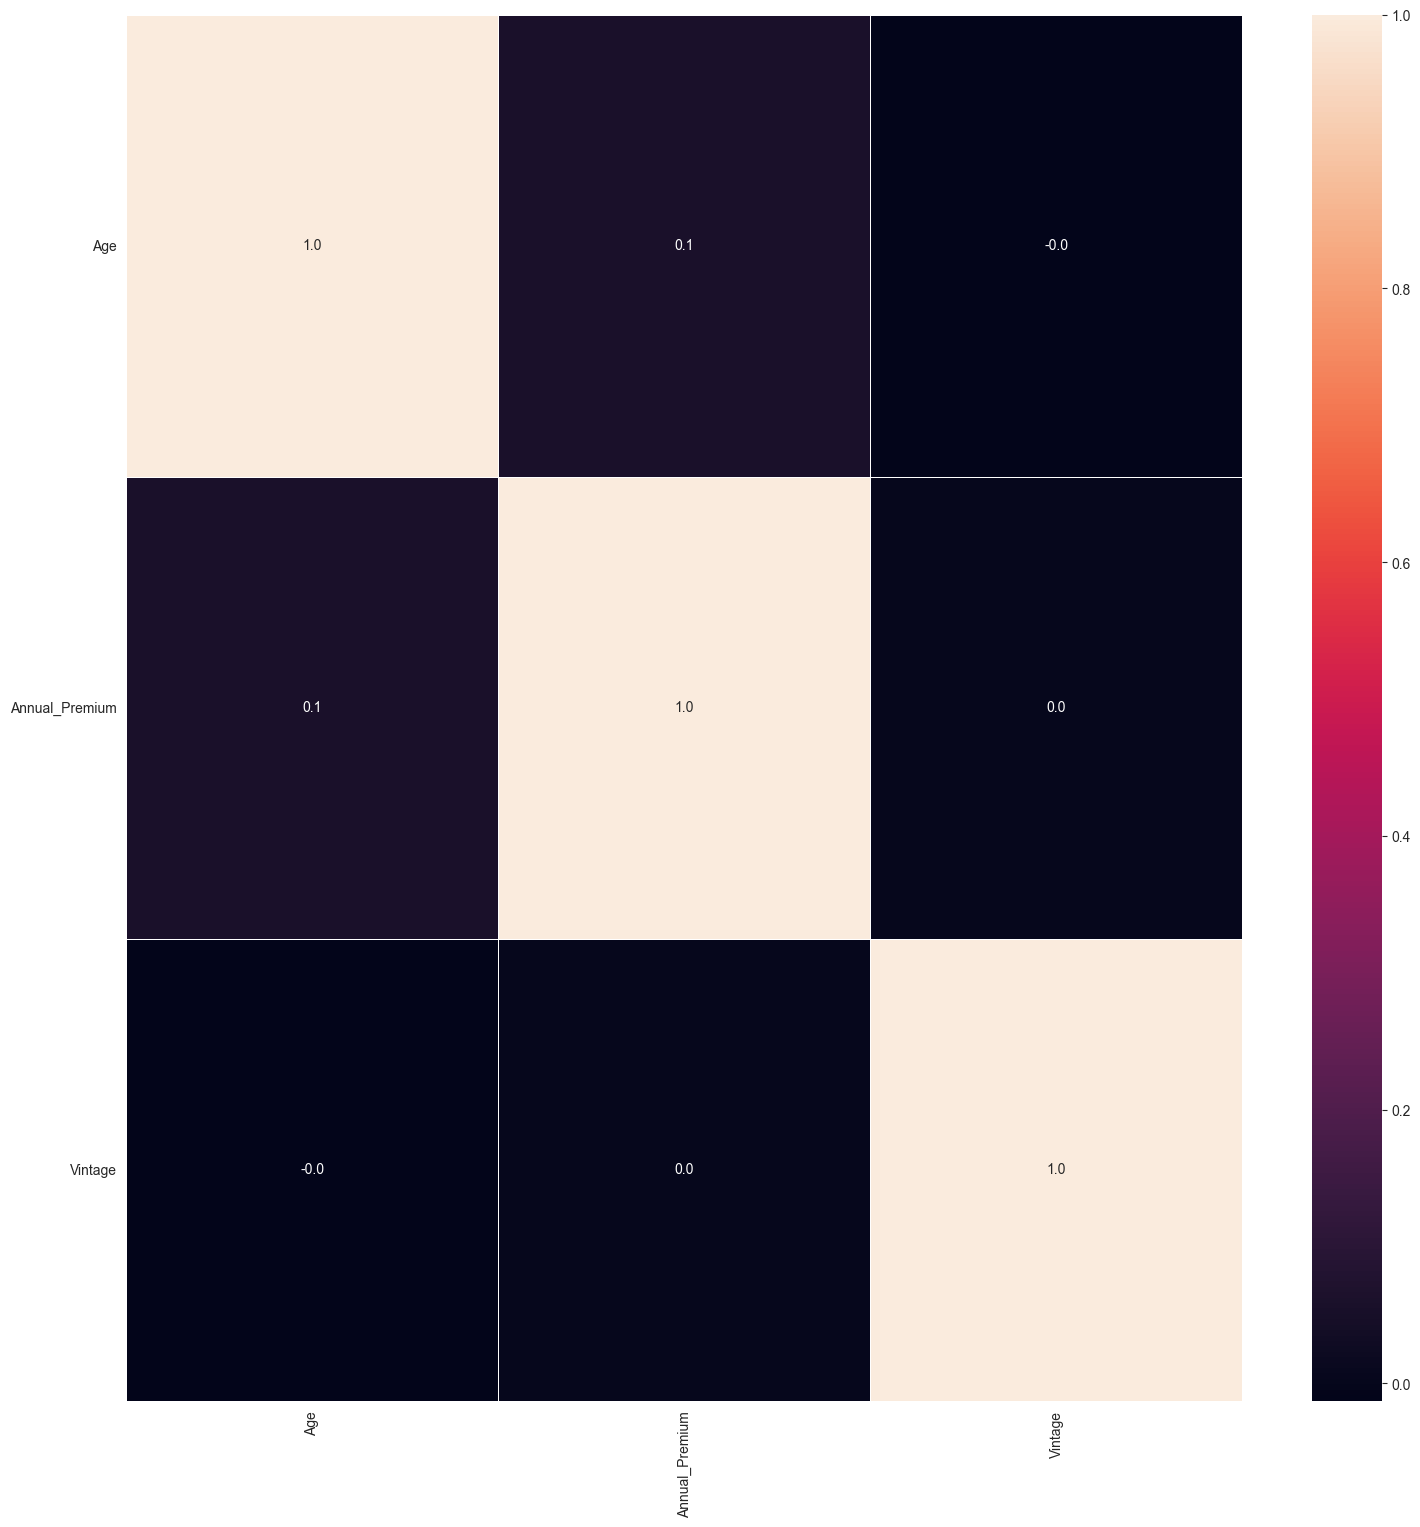

In [11]:
num_df = train_sample[["Age","Annual_Premium","Vintage"]]
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(num_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
# This sets the yticks "upright" with 0, as opposed to sideways with 90.
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.show()
plt.close("all")




## X, y split

In [12]:

from sklearn.model_selection import train_test_split
from pandas.api.types import CategoricalDtype

# drop id columns
train.drop(["id"],axis = 1, inplace = True)

# features
x_train = train.drop(["Response"], axis = 1)
# label
y_train = train.Response

X_data, X_valid, y_data,y_valid =  train_test_split(x_train, y_train, test_size=0.25,  random_state=42, stratify = y_train)

# sample split
train_sample.drop(["id"],axis = 1, inplace = True)

# features
xs_train = train_sample.drop(["Response"], axis = 1)
# label
ys_train = train_sample.Response

Xs_data, Xs_valid, ys_data,ys_valid =  train_test_split(xs_train, ys_train, test_size=0.25,  random_state=42, stratify = ys_train)


## Bivariate visualization

### Numerical 

#### Violin 

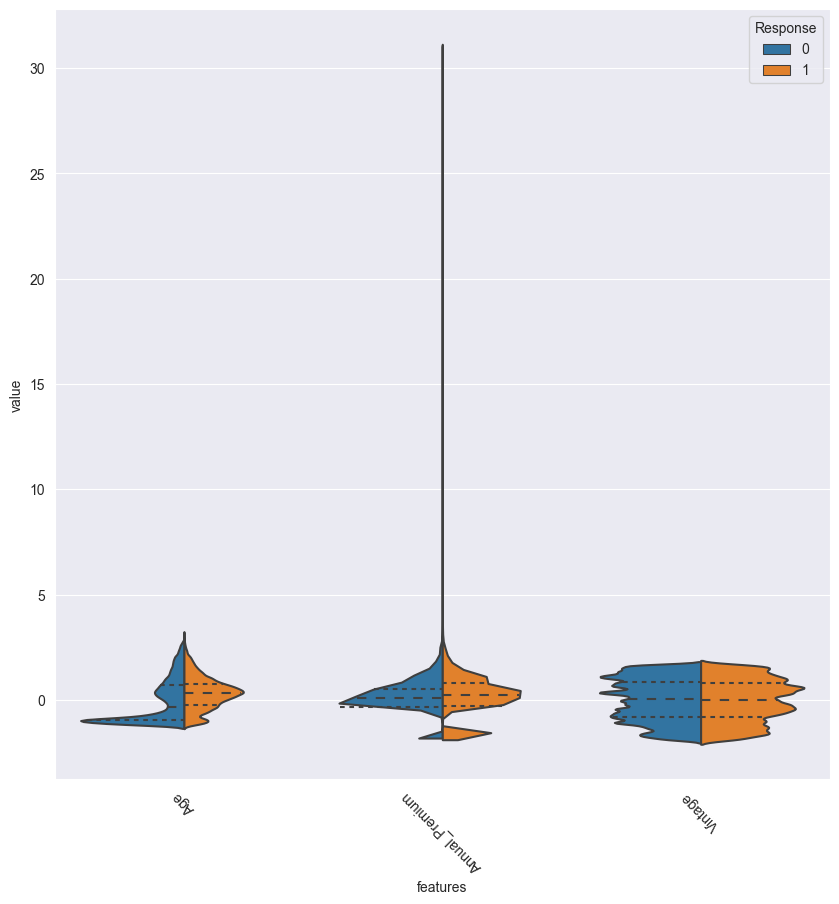

In [13]:
data_num = xs_train[["Age","Annual_Premium","Vintage"]]
data_n_2 = (data_num - data_num.mean()) / (data_num.std())              # standardization
data = pd.concat([ys_train,data_n_2.iloc[:,0:3]],axis=1)
data = pd.melt(data,id_vars="Response",
                    var_name="features",
                    value_name='value')

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Response", data=data,split=True, inner="quart")
plt.xticks(rotation=135)
plt.show()
plt.close("all")


The outliers are making our plot very compressed. Let's remove them to see the underlying distribution differences.

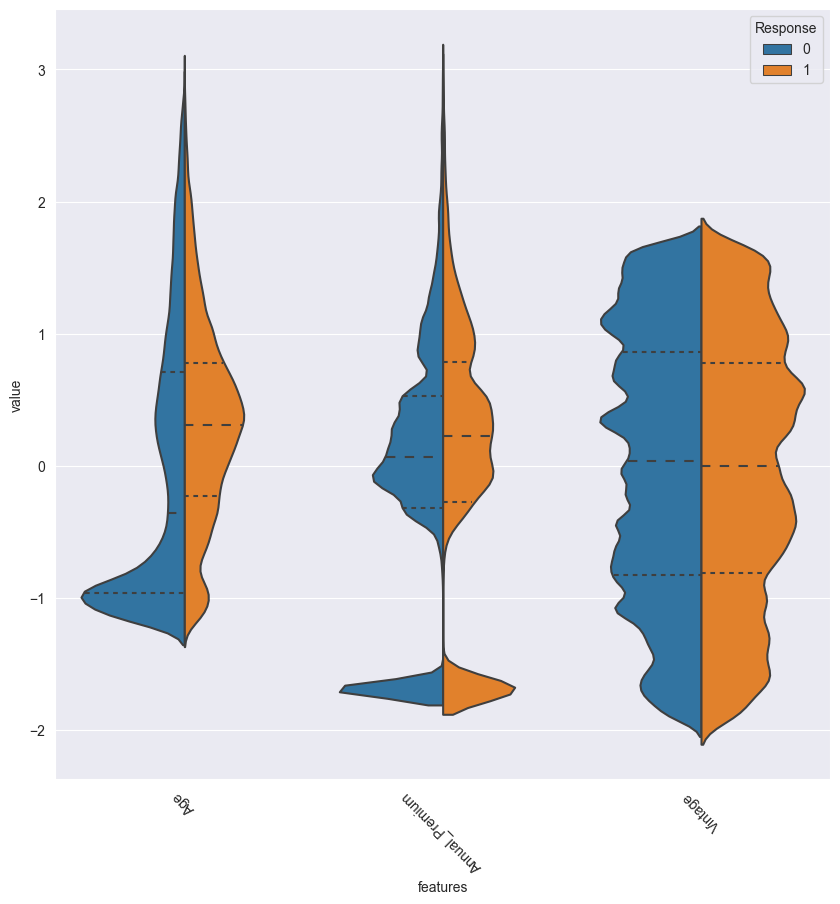

In [14]:

# remove outliers on 3 std 
data_removeoutlier =  data[(data["value"]<3) & (data["value"]>-3)]
data_removeoutlier.info
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="Response", data=data_removeoutlier,split=True, inner="quart")
plt.xticks(rotation=135)
plt.show()
plt.close("all")


As we suspected from the univariate, Annual_premium contains some very large outliers. However, we also see that there appears to be a bimodal distribution with the extreme outliers removed. Another observation to make is that those that bought more services (cross sell - response variable) have age distributions centered past 0, whereas those that didn't appear to be much younger. My hunch is that those who are younger tend to have less disposable income to spare.

### Categorical

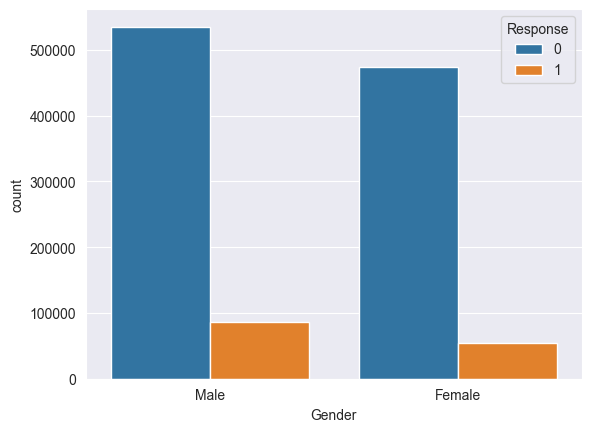

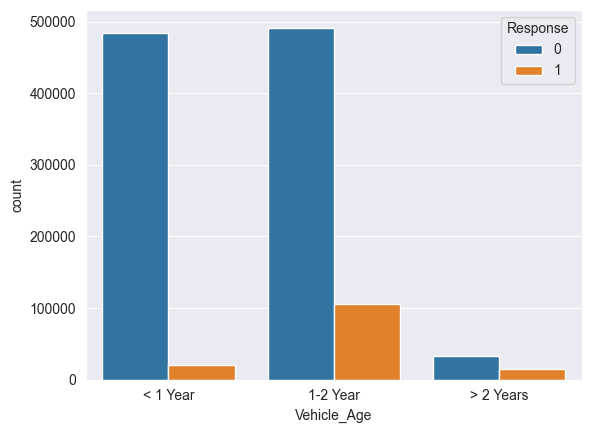

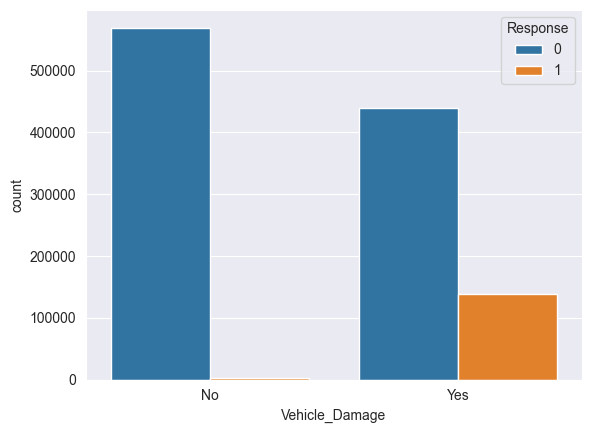

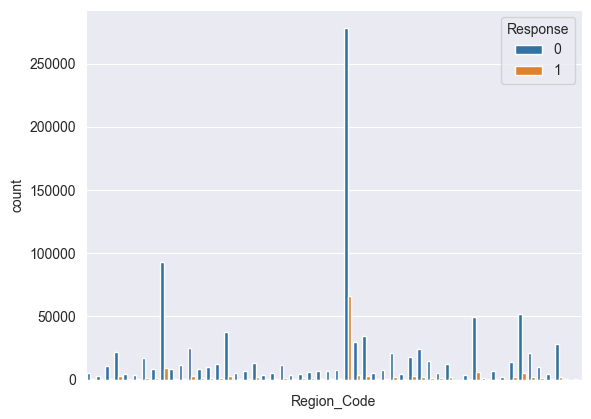

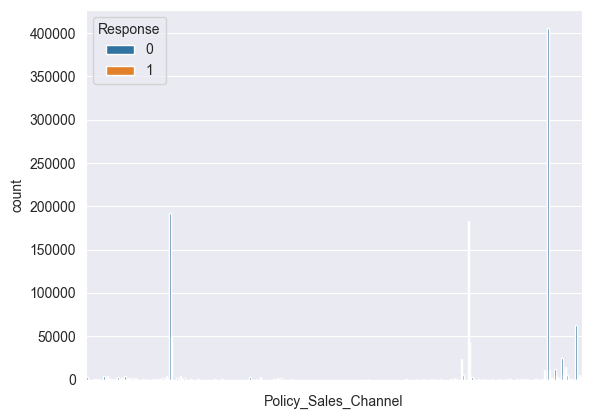

In [15]:
cat_data = pd.concat([ys_train,cat_df],axis=1)

for col in cat_df.columns:
    cat_compare = sns.countplot(cat_data, x=col, hue="Response")
    if col in ["Region_Code", "Policy_Sales_Channel"]: 
        cat_compare.set(xticklabels = [])
            
    plt.show()
    plt.close("all")


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from pandas.api.types import CategoricalDtype

# convert identified categorical types
for col in ['Policy_Sales_Channel','Region_Code']:
    X_data[col] = X_data[col].astype('category')

cat_dtype = CategoricalDtype(
    categories=['< 1 Year','1-2 Year','> 2 Years'], ordered=True)
X_data['Vehicle_Age'] = X_data['Vehicle_Age'].astype(cat_dtype)

# grab columns by type
nominal_col = train_sample.select_dtypes(include = ['category','object']).columns.drop("Vehicle_Age")
num_col = data_num.columns
ordered_col = ["Vehicle_Age"]

# numerical transformer
num_pipe = Pipeline(steps=[
    ("standardize", StandardScaler()) # standardize
])
# categorical transformer
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ord_pipe = Pipeline(steps=[
    ("ord", OrdinalEncoder())
])

preprocess = ColumnTransformer(
    transformers=[
        ("ordinal",ord_pipe, ordered_col ),
        ("numerical", num_pipe, num_col),
        ("categorical", cat_pipe, nominal_col),
    ],
    remainder = "passthrough"
)

# Model fit and evaluation

## Models

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

lor = LogisticRegression(solver = "sag")
svc = SVC(kernel='sigmoid',gamma=0.1)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
bagg = BaggingClassifier()
rf = RandomForestClassifier()
ada = AdaBoostClassifier()
etc = ExtraTreesClassifier()
gra = GradientBoostingClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
dumb = DummyClassifier(strategy = ['most_frequent'])

clfs = {
     'dumb': dumb,
     'lor':lor,
   #  'SVC':svc,
     'knn':knn,
     'dt':dt,
     'rf':rf,
     'bagg':bagg,
     'ada':ada,
     'etc':etc,
     'gra':gra,
     'xgb':xgb,
     'lgbm':lgbm
     
}

## Fit loop

In [18]:

from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score

def Train_Model(clf,x_train,y_train,x_test,y_test):
     
     pipeline = Pipeline(steps=[
          ('column_tran',preprocess),
          ('model',clf)
     ])

     pipeline.fit(x_train,y_train)
     y_pred = pipeline.predict(x_test)
     acc = accuracy_score(y_test,y_pred)
     ps = precision_score(y_test,y_pred)
     rec = recall_score(y_test,y_pred)
     f1 = f1_score(y_test,y_pred)
     return acc , ps ,rec, f1

## Fit models

In [19]:
from tqdm import tqdm

acc_score = []
pre_score = []
recall = []
f1s = []

for key,value in tqdm(clfs.items()):
     acc,ps,rs,f1 = Train_Model(value,Xs_data,ys_data,Xs_valid,ys_valid)

     print("name:",key)
     print('ac:',acc)
     print('ps :',ps)
     print('rs:',rs)
     print('f1:',f1)
     
     acc_score.append(acc)
     pre_score.append(ps)
     recall.append(rs)
     f1s.append(f1)

  0%|          | 0/11 [00:01<?, ?it/s]


InvalidParameterError: The 'strategy' parameter of DummyClassifier must be a str among {'uniform', 'constant', 'prior', 'stratified', 'most_frequent'}. Got ['most_frequent'] instead.

## Model evaluation

In [ ]:
model_df = pd.DataFrame({'Algoritham':clfs.keys(),'Accuracy Score':acc_score,'Precision Score':pre_score,'Recall Score':recall,'F1 Score':f1s}).sort_values('Accuracy Score',ascending=False)
model_df

Based on accuracy alone, XGB stands out as the best model. We'll try using a voting classifier again as an initial model.

# Vote classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[
     ('xgb',xgb),
     ('gra',gra),
     ('lgbm',lgbm)], voting = 'soft')

vote_pipeline = Pipeline(steps=[
     ('colums_tran',preprocess),
     ('model',vote)
])

vote_pipeline.fit(Xs_data, ys_data)


In [ ]:
import joblib
joblib.dump(vote_pipeline, 'vote_classifier', compress=9)